# Covid 19 Identification with Chest X Ray


Created By Lalith Kahatapitiya at [PGIS](http://www.pgis.pdn.ac.lk/) - University of Peradeniya

# Data set Credit :
1. [Covid Chest X Ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset)
2. [Pneumonia dataset by Praveen](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset)
3. [COVID19 chest XRAY analysis by SAIMANASA_C](https://www.kaggle.com/code/saimanasachadalavada/covid19-chest-xray-analysis/data)
4. [COVID19 with Pneumonia and Normal Chest Xray(PA) Dataset by AMANULLAH ASRAF](https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset)
5. [HASH_Directors - Covid19 by AMRUTH AMBRISH K](https://www.kaggle.com/code/amruthambrish/hash-directors-covid19/data)
6. [RICORD COVID-19 X-ray positive tests by RADDAR](https://www.kaggle.com/datasets/raddar/ricord-covid19-xray-positive-tests)


# This is the result from each version run on the Kaggle.

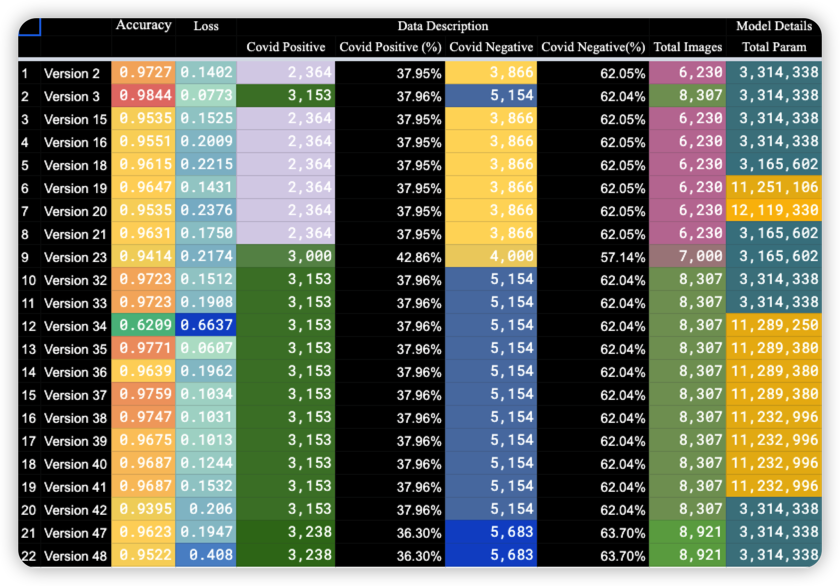


[Datasheet](https://docs.google.com/spreadsheets/d/1wtD3Gx3iLCJO_bs5j1wgDMO9EsDAjMM1aXyK1AUhnHY/edit?usp=sharing)

# System Parameter show




In [1]:
import sys
import platform
import os
import datetime
import pytz
timezone = pytz.timezone("Asia/Colombo")
import random

import shutil

import tensorflow.keras
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print()
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
print(f"Open CV {cv2.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


# def working_dir_clean():
#     list_all_file=os.listdir("./")
#     for file_name in list_all_file:
#         try:
#             shutil.rmtree("./"+file_name)
#             print(f"Remove File Name : {file_name}")
        
#         except Exception as e:
#             print('Exception:',e)
#                     #if any exception rasied, the exception will be printed here. And pass to the next image
        
# working_dir_clean()

Python Platform: macOS-12.6-arm64-arm-64bit
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
Open CV 4.6.0

GPU is available


# Data Set Location Verified and Find Image's Folder

In [2]:
# image data set_path mapping check folder names
dataset_path = 'TRAINING'
# categories = os.listdir(dataset_path)
# print(categories)

# Data Labels creation

In [3]:
categories_all = os.listdir(dataset_path)
categories = []
for category in categories_all:
    if (category == ".DS_Store"):
        continue
    else:
        categories.append(category)

labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))  # empty dictionary


print(label_dict)
print(categories)
print(labels)

{'NORMAL': 0, 'COVID': 1}
['NORMAL', 'COVID']
[0, 1]


# Images count in each folder

In [4]:
# "COVID-19"
folder_path_covid =[
    "TRAINING/COVID",
]


img_path_covid_old =[]
for folder_path in folder_path_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_covid_old.append(img_path)
        


# "NON-COVID"
folder_path_non_covid =[
"TRAINING/NORMAL",
]



img_path_non_covid_old =[]
for folder_path in folder_path_non_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_non_covid_old.append(img_path)

        # images array shuffles
img_path_covid_old = random.sample(img_path_covid_old, len(img_path_covid_old))
img_path_non_covid_old = random.sample(img_path_non_covid_old, len(img_path_non_covid_old))
 
total_ca_images = len(img_path_covid_old) + len(img_path_non_covid_old)

print(f"Containe Covid images count     : {len(img_path_covid_old)}")           
print(f"Non covid images count : {len(img_path_non_covid_old)}")   
print(f"All images count       : {total_ca_images} \n")     
        
#  images array lenth 
# divider = 15
# middle_img_path_covid = int(len(img_path_covid_old)/divider)
# middle_img_path_non_covid = int(len(img_path_non_covid_old)/divider)

middle_img_path_covid = 4099
middle_img_path_non_covid = middle_img_path_covid

img_path_covid =img_path_covid_old[:middle_img_path_covid]
img_path_non_covid =img_path_non_covid_old[:middle_img_path_non_covid]

total_images = len(img_path_non_covid) + len(img_path_covid)

print(f"Covid images count     : {len(img_path_covid)}")           
print(f"Non covid images count : {len(img_path_non_covid)}")   
print(f"All images count       : {total_images}") 
print(f"Covid images           : {round((len(img_path_covid)/total_images)*100, 2)} %")           
print(f"Non covid images       : {round((len(img_path_non_covid)/total_images)*100, 2)} %")  

Containe Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460 

Covid images count     : 4099
Non covid images count : 4099
All images count       : 8198
Covid images           : 50.0 %
Non covid images       : 50.0 %


# Read selected images to array

In [5]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start images reading :{start_time}")
img_size = 224
data = []
target = []
covid = []
normal = []


def image_read(img_path):
    img = cv2.imread(img_path)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Coverting the image into gray scale
        resized = cv2.resize(gray, (img_size, img_size))
        # resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
        return True, resized

    except Exception as e:

        # if any exception rasied, the exception will be return here. And pass to the next image
        return False, e


for img_path in img_path_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("non covid images error")
    else:
        covid.append(resized)
        target.append(label_dict["COVID"])


for img_path in img_path_non_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("covid images error")
    else:
        normal.append(resized)
        target.append(label_dict["NORMAL"])


data = covid + normal
end_time = datetime.datetime.now(tz=timezone)
print(f"End images reading :{end_time}")

print(f"Total time taken {end_time-start_time}")


Start images reading :2022-10-26 12:02:35.674629+05:30


libpng warning: cHRM: invalid values


End images reading :2022-10-26 12:04:15.521875+05:30
Total time taken 0:01:39.847246


# Normal Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 316.10it/s]


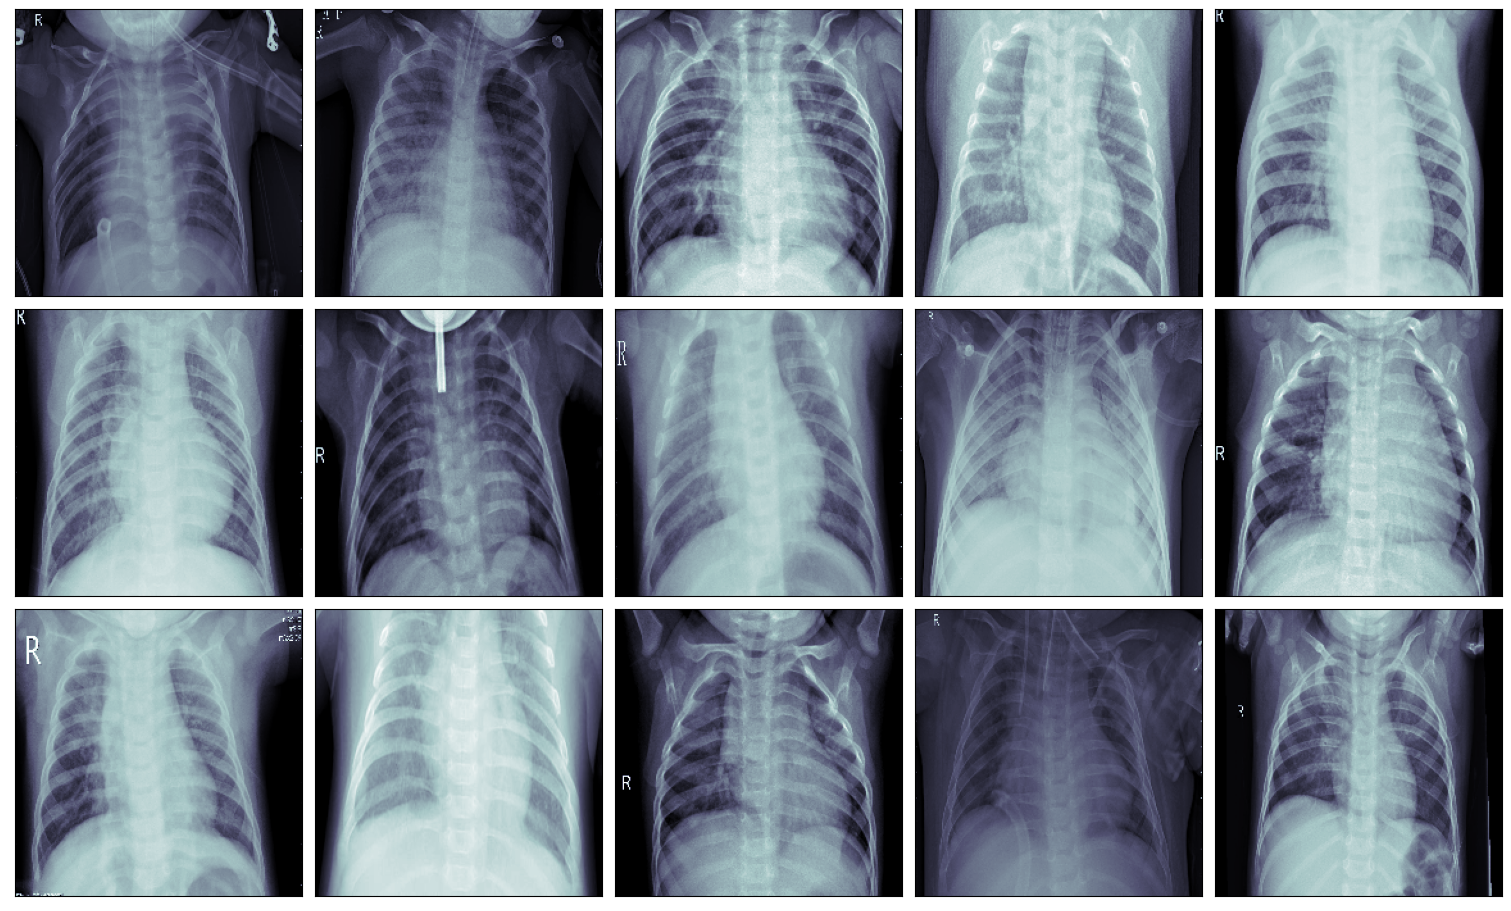

In [6]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        ax[row][col].imshow(normal[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Covid Positive Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 540.64it/s]


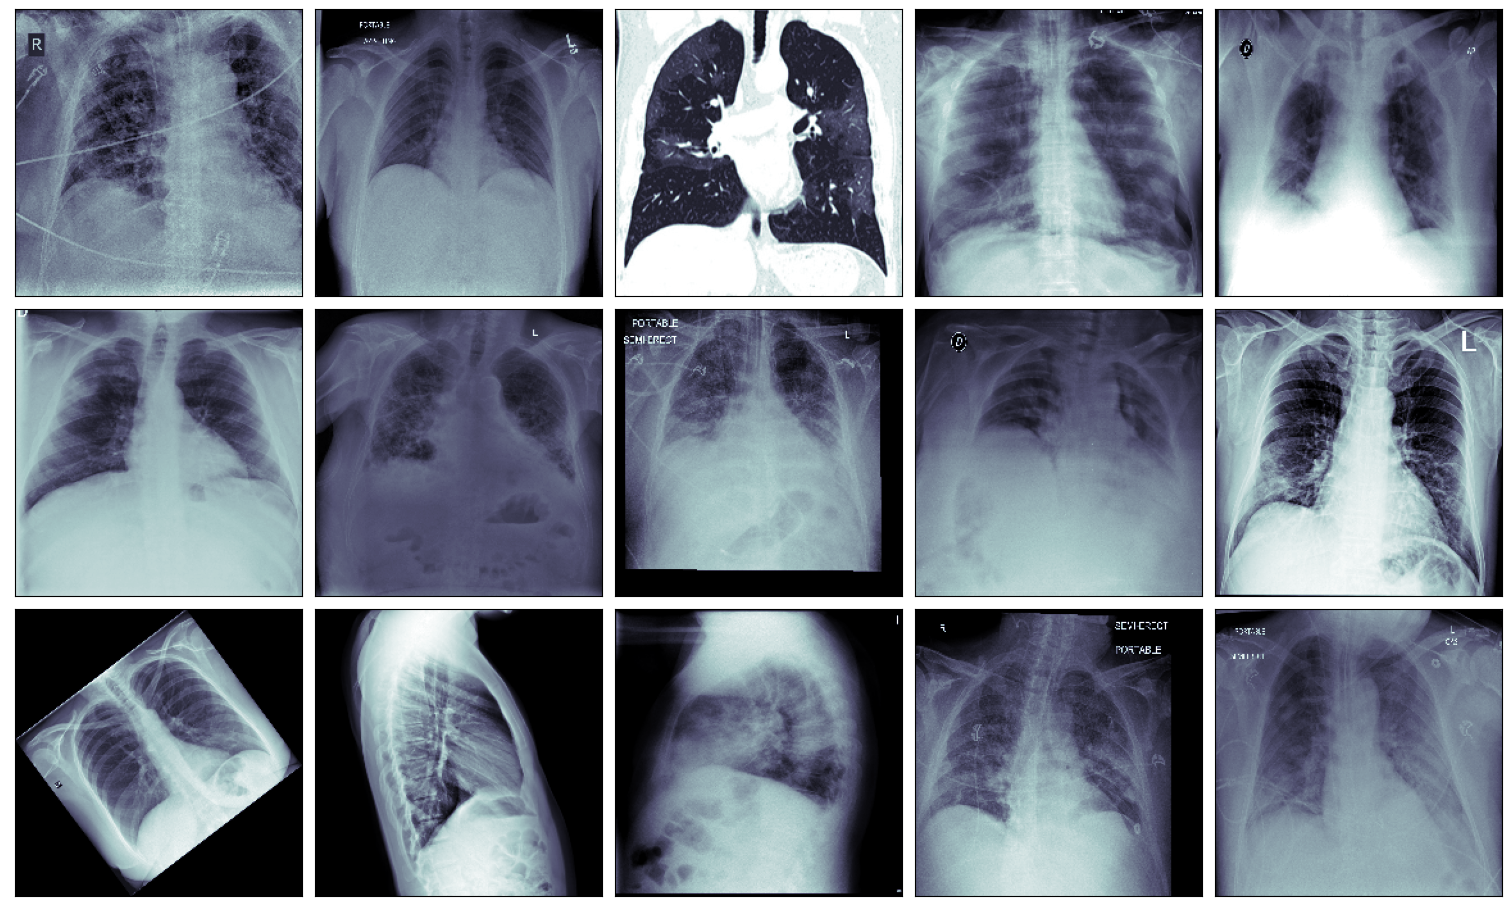

In [7]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(covid[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Wanbd configuration 

In [8]:
wandb_api_key = '52c82ac93c7b3a43eab4eee3ee4264af086187eb'
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback


start_time = datetime.datetime.now(tz=timezone)
name =f'{start_time}-model-run'
wandb.init(
    project="covid-19-identification-with-chest-x-ray",
    name=name
)
# wandb. init(mode="disabled")

W&B:  0.13.4


wandb: Currently logged in as: lalithk90. Use `wandb login --relogin` to force relogin


# Data array transfer to numpy array and change shape

In [9]:

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


new_target=tf.keras.utils.to_categorical(target)


print(f"Data shape : {data.shape} \nTarget shape : {target.shape} \nNew Target shape : {new_target.shape}")

Data shape : (8198, 224, 224, 1) 
Target shape : (8198,) 
New Target shape : (8198, 2)


# Model Creation



In [10]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint


input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):
    if(k !=0):
        conv = Conv2D(128, kernel_size = k,padding = 'same' ,activation='relu')(inp)

        convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

# Hidden Layer 2
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden Layer 3
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Output layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='sigmoid'))



Metal device set to: Apple M1 Pro


2022-10-26 12:04:23.608737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-26 12:04:23.608892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
METRICS = [
    'accuracy',
    "sparse_categorical_accuracy",
    'mean_squared_error',
    'mean_absolute_error',
    'mean_absolute_percentage_error',
    'mean_squared_logarithmic_error',
    'cosine_similarity',
    'logcosh',
]

LOSS = 'sparse_categorical_crossentropy'

OPTIMIZER = 'adam'

model.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 256)     896       
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      147520    
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                        

In [13]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

print(type (train_data))
print(f"Training Data shape : {train_data.shape} \nTraining Target shape : {train_target.shape}")
print(f"Test Data shape : {test_data.shape} \nTest Target shape : {test_target.shape}")

<class 'numpy.ndarray'>
Training Data shape : (7378, 224, 224, 1) 
Training Target shape : (7378,)
Test Data shape : (820, 224, 224, 1) 
Test Target shape : (820,)


In [14]:


start_time = datetime.datetime.now(tz=timezone)
print(f"Start checkpoint creation:{start_time}")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

print(len(train_data))
history=model.fit(train_data,
                  train_target,
                  epochs = 25,
                  callbacks=[checkpoint],
                  validation_data = (test_data,test_target))

end_time = datetime.datetime.now(tz=timezone)
print(f"End checkpoint creation:{end_time}")
print(f"Total time taken {end_time-start_time}")

Start checkpoint creation:2022-10-26 12:04:26.628971+05:30
7378
Epoch 1/25


2022-10-26 12:04:30.542688: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-26 12:04:31.122306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 19/231 [=>............................] - ETA: 3:40 - loss: 0.9539 - accuracy: 0.5263 - sparse_categorical_accuracy: 0.5263 - mean_squared_error: 0.2617 - mean_absolute_error: 0.4967 - mean_absolute_percentage_error: 247505456.0000 - mean_squared_logarithmic_error: 0.1292 - cosine_similarity: 0.6991 - logcosh: 0.1245

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d9c68630>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/231 [=====>........................] - ETA: 3:05 - loss: 0.7005 - accuracy: 0.6492 - sparse_categorical_accuracy: 0.6492 - mean_squared_error: 0.2570 - mean_absolute_error: 0.4852 - mean_absolute_percentage_error: 243397968.0000 - mean_squared_logarithmic_error: 0.1264 - cosine_similarity: 0.6817 - logcosh: 0.1221

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d56e3330>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/231 [=====>........................] - ETA: 3:02 - loss: 0.6809 - accuracy: 0.6599 - sparse_categorical_accuracy: 0.6599 - mean_squared_error: 0.2605 - mean_absolute_error: 0.4846 - mean_absolute_percentage_error: 243327504.0000 - mean_squared_logarithmic_error: 0.1279 - cosine_similarity: 0.6765 - logcosh: 0.1234

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d86e8ed0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/231 [======>.......................] - ETA: 2:56 - loss: 0.6476 - accuracy: 0.6875 - sparse_categorical_accuracy: 0.6875 - mean_squared_error: 0.2687 - mean_absolute_error: 0.4818 - mean_absolute_percentage_error: 241424752.0000 - mean_squared_logarithmic_error: 0.1312 - cosine_similarity: 0.6687 - logcosh: 0.1265

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d56fabc0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/231 [=========>....................] - ETA: 2:31 - loss: 0.5564 - accuracy: 0.7561 - sparse_categorical_accuracy: 0.7561 - mean_squared_error: 0.2802 - mean_absolute_error: 0.4726 - mean_absolute_percentage_error: 230135520.0000 - mean_squared_logarithmic_error: 0.1355 - cosine_similarity: 0.6583 - logcosh: 0.1305

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d9c57e80>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/231 [===========>..................] - ETA: 2:17 - loss: 0.5144 - accuracy: 0.7793 - sparse_categorical_accuracy: 0.7793 - mean_squared_error: 0.2829 - mean_absolute_error: 0.4694 - mean_absolute_percentage_error: 227305648.0000 - mean_squared_logarithmic_error: 0.1364 - cosine_similarity: 0.6560 - logcosh: 0.1314

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d82f9af0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


125/231 [===============>..............] - ETA: 1:46 - loss: 0.4398 - accuracy: 0.8138 - sparse_categorical_accuracy: 0.8138 - mean_squared_error: 0.2940 - mean_absolute_error: 0.4612 - mean_absolute_percentage_error: 222194112.0000 - mean_squared_logarithmic_error: 0.1414 - cosine_similarity: 0.6424 - logcosh: 0.1354

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d9c5d240>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


133/231 [================>.............] - ETA: 1:38 - loss: 0.4272 - accuracy: 0.8212 - sparse_categorical_accuracy: 0.8212 - mean_squared_error: 0.2973 - mean_absolute_error: 0.4602 - mean_absolute_percentage_error: 219455104.0000 - mean_squared_logarithmic_error: 0.1429 - cosine_similarity: 0.6435 - logcosh: 0.1367

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d87b5340>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


205/231 [=========================>....] - ETA: 25s - loss: 0.3432 - accuracy: 0.8648 - sparse_categorical_accuracy: 0.8648 - mean_squared_error: 0.3000 - mean_absolute_error: 0.4515 - mean_absolute_percentage_error: 214396896.0000 - mean_squared_logarithmic_error: 0.1439 - cosine_similarity: 0.6334 - logcosh: 0.1374

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x4d82e8c10>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8748 - sparse_categorical_accuracy: 0.8748 - mean_squared_error: 0.3043 - mean_absolute_error: 0.4500 - mean_absolute_percentage_error: 214918432.0000 - mean_squared_logarithmic_error: 0.1459 - cosine_similarity: 0.6273 - logcosh: 0.1390

2022-10-26 12:08:23.495389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.96951, saving model to model-001.model


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


231/231 [==============================] - 245s 1s/step - loss: 0.3199 - accuracy: 0.8748 - sparse_categorical_accuracy: 0.8748 - mean_squared_error: 0.3043 - mean_absolute_error: 0.4500 - mean_absolute_percentage_error: 214918432.0000 - mean_squared_logarithmic_error: 0.1459 - cosine_similarity: 0.6273 - logcosh: 0.1390 - val_loss: 0.1065 - val_accuracy: 0.9695 - val_sparse_categorical_accuracy: 0.9695 - val_mean_squared_error: 0.3196 - val_mean_absolute_error: 0.4392 - val_mean_absolute_percentage_error: 211532368.0000 - val_mean_squared_logarithmic_error: 0.1554 - val_cosine_similarity: 0.5819 - val_logcosh: 0.1453
Epoch 2/25
231/231 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9603 - sparse_categorical_accuracy: 0.9603 - mean_squared_error: 0.3389 - mean_absolute_error: 0.4374 - mean_absolute_percentage_error: 208962368.0000 - mean_squared_logarithmic_error: 0.1629 - cosine_similarity: 0.5837 - logcosh: 0.1522
Epoch 2: val_accuracy improved from 0.96951 t

INFO:tensorflow:Assets written to: model-002.model/assets


INFO:tensorflow:Assets written to: model-002.model/assets


231/231 [==============================] - 232s 1s/step - loss: 0.1239 - accuracy: 0.9603 - sparse_categorical_accuracy: 0.9603 - mean_squared_error: 0.3389 - mean_absolute_error: 0.4374 - mean_absolute_percentage_error: 208962368.0000 - mean_squared_logarithmic_error: 0.1629 - cosine_similarity: 0.5837 - logcosh: 0.1522 - val_loss: 0.1139 - val_accuracy: 0.9720 - val_sparse_categorical_accuracy: 0.9720 - val_mean_squared_error: 0.3850 - val_mean_absolute_error: 0.4526 - val_mean_absolute_percentage_error: 211446016.0000 - val_mean_squared_logarithmic_error: 0.1907 - val_cosine_similarity: 0.5256 - val_logcosh: 0.1713
Epoch 3/25
231/231 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9714 - sparse_categorical_accuracy: 0.9714 - mean_squared_error: 0.3504 - mean_absolute_error: 0.4345 - mean_absolute_percentage_error: 206496464.0000 - mean_squared_logarithmic_error: 0.1686 - cosine_similarity: 0.5713 - logcosh: 0.1566
Epoch 3: val_accuracy improved from 0.97195 t

INFO:tensorflow:Assets written to: model-003.model/assets


INFO:tensorflow:Assets written to: model-003.model/assets


231/231 [==============================] - 239s 1s/step - loss: 0.0862 - accuracy: 0.9714 - sparse_categorical_accuracy: 0.9714 - mean_squared_error: 0.3504 - mean_absolute_error: 0.4345 - mean_absolute_percentage_error: 206496464.0000 - mean_squared_logarithmic_error: 0.1686 - cosine_similarity: 0.5713 - logcosh: 0.1566 - val_loss: 0.0525 - val_accuracy: 0.9829 - val_sparse_categorical_accuracy: 0.9829 - val_mean_squared_error: 0.3570 - val_mean_absolute_error: 0.4424 - val_mean_absolute_percentage_error: 215287120.0000 - val_mean_squared_logarithmic_error: 0.1720 - val_cosine_similarity: 0.5673 - val_logcosh: 0.1603
Epoch 4/25
144/231 [=================>............] - ETA: 1:32 - loss: 0.0763 - accuracy: 0.9742 - sparse_categorical_accuracy: 0.9742 - mean_squared_error: 0.3587 - mean_absolute_error: 0.4373 - mean_absolute_percentage_error: 210860256.0000 - mean_squared_logarithmic_error: 0.1725 - cosine_similarity: 0.5659 - logcosh: 0.1600

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2facacf30>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


199/231 [========================>.....] - ETA: 33s - loss: 0.0712 - accuracy: 0.9769 - sparse_categorical_accuracy: 0.9769 - mean_squared_error: 0.3624 - mean_absolute_error: 0.4380 - mean_absolute_percentage_error: 212267600.0000 - mean_squared_logarithmic_error: 0.1741 - cosine_similarity: 0.5630 - logcosh: 0.1615

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fac99f40>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


229/231 [============================>.] - ETA: 2s - loss: 0.0689 - accuracy: 0.9773 - sparse_categorical_accuracy: 0.9773 - mean_squared_error: 0.3629 - mean_absolute_error: 0.4376 - mean_absolute_percentage_error: 209647296.0000 - mean_squared_logarithmic_error: 0.1744 - cosine_similarity: 0.5659 - logcosh: 0.1616

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a695f680>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9774 - sparse_categorical_accuracy: 0.9774 - mean_squared_error: 0.3630 - mean_absolute_error: 0.4376 - mean_absolute_percentage_error: 209820832.0000 - mean_squared_logarithmic_error: 0.1745 - cosine_similarity: 0.5656 - logcosh: 0.1617
Epoch 4: val_accuracy did not improve from 0.98293
231/231 [==============================] - 255s 1s/step - loss: 0.0687 - accuracy: 0.9774 - sparse_categorical_accuracy: 0.9774 - mean_squared_error: 0.3630 - mean_absolute_error: 0.4376 - mean_absolute_percentage_error: 209820832.0000 - mean_squared_logarithmic_error: 0.1745 - cosine_similarity: 0.5656 - logcosh: 0.1617 - val_loss: 0.0535 - val_accuracy: 0.9793 - val_sparse_categorical_accuracy: 0.9793 - val_mean_squared_error: 0.3813 - val_mean_absolute_error: 0.4462 - val_mean_absolute_percentage_error: 208651104.0000 - val_mean_squared_logarithmic_error: 0.1870 - val_cosine_similarity: 0.5353 - val_logcosh: 0.1699
Epoch

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a695f2d0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/231 [====>.........................] - ETA: 3:18 - loss: 0.0550 - accuracy: 0.9808 - sparse_categorical_accuracy: 0.9808 - mean_squared_error: 0.3743 - mean_absolute_error: 0.4443 - mean_absolute_percentage_error: 214758288.0000 - mean_squared_logarithmic_error: 0.1804 - cosine_similarity: 0.5472 - logcosh: 0.1664

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c874b110>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9833 - sparse_categorical_accuracy: 0.9833 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4439 - mean_absolute_percentage_error: 211100768.0000 - mean_squared_logarithmic_error: 0.1834 - cosine_similarity: 0.5510 - logcosh: 0.1687
Epoch 5: val_accuracy improved from 0.98293 to 0.98415, saving model to model-005.model


INFO:tensorflow:Assets written to: model-005.model/assets


INFO:tensorflow:Assets written to: model-005.model/assets


231/231 [==============================] - 235s 1s/step - loss: 0.0474 - accuracy: 0.9833 - sparse_categorical_accuracy: 0.9833 - mean_squared_error: 0.3801 - mean_absolute_error: 0.4439 - mean_absolute_percentage_error: 211100768.0000 - mean_squared_logarithmic_error: 0.1834 - cosine_similarity: 0.5510 - logcosh: 0.1687 - val_loss: 0.0423 - val_accuracy: 0.9841 - val_sparse_categorical_accuracy: 0.9841 - val_mean_squared_error: 0.4091 - val_mean_absolute_error: 0.4598 - val_mean_absolute_percentage_error: 219845552.0000 - val_mean_squared_logarithmic_error: 0.2000 - val_cosine_similarity: 0.5251 - val_logcosh: 0.1811
Epoch 6/25
 13/231 [>.............................] - ETA: 3:21 - loss: 0.0589 - accuracy: 0.9808 - sparse_categorical_accuracy: 0.9808 - mean_squared_error: 0.3899 - mean_absolute_error: 0.4464 - mean_absolute_percentage_error: 212063440.0000 - mean_squared_logarithmic_error: 0.1893 - cosine_similarity: 0.5446 - logcosh: 0.1725

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a696b130>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


219/231 [===========================>..] - ETA: 20s - loss: 0.0419 - accuracy: 0.9870 - sparse_categorical_accuracy: 0.9870 - mean_squared_error: 0.3833 - mean_absolute_error: 0.4408 - mean_absolute_percentage_error: 211652176.0000 - mean_squared_logarithmic_error: 0.1850 - cosine_similarity: 0.5484 - logcosh: 0.1697

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff132050>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9877 - sparse_categorical_accuracy: 0.9877 - mean_squared_error: 0.3831 - mean_absolute_error: 0.4406 - mean_absolute_percentage_error: 211329152.0000 - mean_squared_logarithmic_error: 0.1849 - cosine_similarity: 0.5495 - logcosh: 0.1696
Epoch 6: val_accuracy improved from 0.98415 to 0.98659, saving model to model-006.model


INFO:tensorflow:Assets written to: model-006.model/assets


INFO:tensorflow:Assets written to: model-006.model/assets


231/231 [==============================] - 387s 2s/step - loss: 0.0407 - accuracy: 0.9877 - sparse_categorical_accuracy: 0.9877 - mean_squared_error: 0.3831 - mean_absolute_error: 0.4406 - mean_absolute_percentage_error: 211329152.0000 - mean_squared_logarithmic_error: 0.1849 - cosine_similarity: 0.5495 - logcosh: 0.1696 - val_loss: 0.0452 - val_accuracy: 0.9866 - val_sparse_categorical_accuracy: 0.9866 - val_mean_squared_error: 0.4102 - val_mean_absolute_error: 0.4604 - val_mean_absolute_percentage_error: 226601152.0000 - val_mean_squared_logarithmic_error: 0.1975 - val_cosine_similarity: 0.5396 - val_logcosh: 0.1816
Epoch 7/25
208/231 [==========================>...] - ETA: 22s - loss: 0.0442 - accuracy: 0.9863 - sparse_categorical_accuracy: 0.9863 - mean_squared_error: 0.3796 - mean_absolute_error: 0.4371 - mean_absolute_percentage_error: 211699904.0000 - mean_squared_logarithmic_error: 0.1825 - cosine_similarity: 0.5561 - logcosh: 0.1681

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6dcb550>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9860 - sparse_categorical_accuracy: 0.9860 - mean_squared_error: 0.3781 - mean_absolute_error: 0.4366 - mean_absolute_percentage_error: 211121312.0000 - mean_squared_logarithmic_error: 0.1818 - cosine_similarity: 0.5559 - logcosh: 0.1675
Epoch 7: val_accuracy did not improve from 0.98659
231/231 [==============================] - 234s 1s/step - loss: 0.0449 - accuracy: 0.9860 - sparse_categorical_accuracy: 0.9860 - mean_squared_error: 0.3781 - mean_absolute_error: 0.4366 - mean_absolute_percentage_error: 211121312.0000 - mean_squared_logarithmic_error: 0.1818 - cosine_similarity: 0.5559 - logcosh: 0.1675 - val_loss: 0.0404 - val_accuracy: 0.9866 - val_sparse_categorical_accuracy: 0.9866 - val_mean_squared_error: 0.3951 - val_mean_absolute_error: 0.4535 - val_mean_absolute_percentage_error: 219811328.0000 - val_mean_squared_logarithmic_error: 0.1913 - val_cosine_similarity: 0.5407 - val_logcosh: 0.1756
Epoch

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6dcae30>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/231 [====>.........................] - ETA: 2:51 - loss: 0.0242 - accuracy: 0.9912 - sparse_categorical_accuracy: 0.9912 - mean_squared_error: 0.4003 - mean_absolute_error: 0.4477 - mean_absolute_percentage_error: 215648256.0000 - mean_squared_logarithmic_error: 0.1932 - cosine_similarity: 0.5402 - logcosh: 0.1766

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c9bc8730>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/231 [=========>....................] - ETA: 2:16 - loss: 0.0253 - accuracy: 0.9906 - sparse_categorical_accuracy: 0.9906 - mean_squared_error: 0.3931 - mean_absolute_error: 0.4443 - mean_absolute_percentage_error: 214487072.0000 - mean_squared_logarithmic_error: 0.1893 - cosine_similarity: 0.5474 - logcosh: 0.1737

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdcbf680>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


111/231 [=============>................] - ETA: 1:50 - loss: 0.0258 - accuracy: 0.9910 - sparse_categorical_accuracy: 0.9910 - mean_squared_error: 0.3900 - mean_absolute_error: 0.4424 - mean_absolute_percentage_error: 213013616.0000 - mean_squared_logarithmic_error: 0.1879 - cosine_similarity: 0.5477 - logcosh: 0.1724

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6d98710>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


119/231 [==============>...............] - ETA: 1:42 - loss: 0.0246 - accuracy: 0.9913 - sparse_categorical_accuracy: 0.9913 - mean_squared_error: 0.3911 - mean_absolute_error: 0.4427 - mean_absolute_percentage_error: 213878784.0000 - mean_squared_logarithmic_error: 0.1885 - cosine_similarity: 0.5450 - logcosh: 0.1728

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2f08802b0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


150/231 [==================>...........] - ETA: 1:15 - loss: 0.0243 - accuracy: 0.9910 - sparse_categorical_accuracy: 0.9910 - mean_squared_error: 0.3944 - mean_absolute_error: 0.4444 - mean_absolute_percentage_error: 211822736.0000 - mean_squared_logarithmic_error: 0.1899 - cosine_similarity: 0.5513 - logcosh: 0.1741

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0x2fdca6d50>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


175/231 [=====================>........] - ETA: 53s - loss: 0.0311 - accuracy: 0.9904 - sparse_categorical_accuracy: 0.9904 - mean_squared_error: 0.3944 - mean_absolute_error: 0.4444 - mean_absolute_percentage_error: 210812112.0000 - mean_squared_logarithmic_error: 0.1900 - cosine_similarity: 0.5517 - logcosh: 0.1741

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c9b2f250>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9908 - sparse_categorical_accuracy: 0.9908 - mean_squared_error: 0.3881 - mean_absolute_error: 0.4414 - mean_absolute_percentage_error: 211824928.0000 - mean_squared_logarithmic_error: 0.1869 - cosine_similarity: 0.5478 - logcosh: 0.1716
Epoch 8: val_accuracy improved from 0.98659 to 0.98902, saving model to model-008.model


INFO:tensorflow:Assets written to: model-008.model/assets


INFO:tensorflow:Assets written to: model-008.model/assets


231/231 [==============================] - 231s 998ms/step - loss: 0.0315 - accuracy: 0.9908 - sparse_categorical_accuracy: 0.9908 - mean_squared_error: 0.3881 - mean_absolute_error: 0.4414 - mean_absolute_percentage_error: 211824928.0000 - mean_squared_logarithmic_error: 0.1869 - cosine_similarity: 0.5478 - logcosh: 0.1716 - val_loss: 0.0353 - val_accuracy: 0.9890 - val_sparse_categorical_accuracy: 0.9890 - val_mean_squared_error: 0.4178 - val_mean_absolute_error: 0.4621 - val_mean_absolute_percentage_error: 229013232.0000 - val_mean_squared_logarithmic_error: 0.2005 - val_cosine_similarity: 0.5362 - val_logcosh: 0.1847
Epoch 9/25
231/231 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9911 - sparse_categorical_accuracy: 0.9911 - mean_squared_error: 0.3975 - mean_absolute_error: 0.4457 - mean_absolute_percentage_error: 214717552.0000 - mean_squared_logarithmic_error: 0.1913 - cosine_similarity: 0.5437 - logcosh: 0.1754
Epoch 9: val_accuracy did not improve from

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdcbe930>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


152/231 [==================>...........] - ETA: 1:16 - loss: 0.0181 - accuracy: 0.9949 - sparse_categorical_accuracy: 0.9949 - mean_squared_error: 0.4029 - mean_absolute_error: 0.4463 - mean_absolute_percentage_error: 216380752.0000 - mean_squared_logarithmic_error: 0.1946 - cosine_similarity: 0.5365 - logcosh: 0.1774

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a5a18fe0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9955 - sparse_categorical_accuracy: 0.9955 - mean_squared_error: 0.4055 - mean_absolute_error: 0.4462 - mean_absolute_percentage_error: 214620784.0000 - mean_squared_logarithmic_error: 0.1961 - cosine_similarity: 0.5364 - logcosh: 0.1784
Epoch 11: val_accuracy did not improve from 0.98902
231/231 [==============================] - 232s 1s/step - loss: 0.0165 - accuracy: 0.9955 - sparse_categorical_accuracy: 0.9955 - mean_squared_error: 0.4055 - mean_absolute_error: 0.4462 - mean_absolute_percentage_error: 214620784.0000 - mean_squared_logarithmic_error: 0.1961 - cosine_similarity: 0.5364 - logcosh: 0.1784 - val_loss: 0.0371 - val_accuracy: 0.9890 - val_sparse_categorical_accuracy: 0.9890 - val_mean_squared_error: 0.4488 - val_mean_absolute_error: 0.4782 - val_mean_absolute_percentage_error: 236869968.0000 - val_mean_squared_logarithmic_error: 0.2157 - val_cosine_similarity: 0.5213 - val_logcosh: 0.1969
Epoc

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff223480>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/231 [===>..........................] - ETA: 3:09 - loss: 0.0028 - accuracy: 0.9991 - sparse_categorical_accuracy: 0.9991 - mean_squared_error: 0.4282 - mean_absolute_error: 0.4519 - mean_absolute_percentage_error: 223543856.0000 - mean_squared_logarithmic_error: 0.2074 - cosine_similarity: 0.5110 - logcosh: 0.1872

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6c2d6c0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/231 [=========>....................] - ETA: 2:21 - loss: 0.0267 - accuracy: 0.9939 - sparse_categorical_accuracy: 0.9939 - mean_squared_error: 0.4271 - mean_absolute_error: 0.4526 - mean_absolute_percentage_error: 216915920.0000 - mean_squared_logarithmic_error: 0.2064 - cosine_similarity: 0.5243 - logcosh: 0.1868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff2efaa0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


135/231 [================>.............] - ETA: 1:29 - loss: 0.0216 - accuracy: 0.9942 - sparse_categorical_accuracy: 0.9942 - mean_squared_error: 0.4161 - mean_absolute_error: 0.4460 - mean_absolute_percentage_error: 213927472.0000 - mean_squared_logarithmic_error: 0.2010 - cosine_similarity: 0.5248 - logcosh: 0.1823

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a5a9aa00>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


138/231 [================>.............] - ETA: 1:26 - loss: 0.0220 - accuracy: 0.9937 - sparse_categorical_accuracy: 0.9937 - mean_squared_error: 0.4161 - mean_absolute_error: 0.4461 - mean_absolute_percentage_error: 213670048.0000 - mean_squared_logarithmic_error: 0.2010 - cosine_similarity: 0.5256 - logcosh: 0.1823

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdca37e0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


168/231 [====================>.........] - ETA: 58s - loss: 0.0233 - accuracy: 0.9931 - sparse_categorical_accuracy: 0.9931 - mean_squared_error: 0.4123 - mean_absolute_error: 0.4449 - mean_absolute_percentage_error: 209819408.0000 - mean_squared_logarithmic_error: 0.1990 - cosine_similarity: 0.5342 - logcosh: 0.1808

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6d76b40>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


172/231 [=====================>........] - ETA: 54s - loss: 0.0232 - accuracy: 0.9931 - sparse_categorical_accuracy: 0.9931 - mean_squared_error: 0.4116 - mean_absolute_error: 0.4446 - mean_absolute_percentage_error: 209875984.0000 - mean_squared_logarithmic_error: 0.1986 - cosine_similarity: 0.5340 - logcosh: 0.1805

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6c5a720>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


186/231 [=======================>......] - ETA: 41s - loss: 0.0227 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - mean_squared_error: 0.4096 - mean_absolute_error: 0.4436 - mean_absolute_percentage_error: 208026608.0000 - mean_squared_logarithmic_error: 0.1976 - cosine_similarity: 0.5364 - logcosh: 0.1797

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff22d2c0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


193/231 [========================>.....] - ETA: 35s - loss: 0.0225 - accuracy: 0.9930 - sparse_categorical_accuracy: 0.9930 - mean_squared_error: 0.4085 - mean_absolute_error: 0.4429 - mean_absolute_percentage_error: 207588944.0000 - mean_squared_logarithmic_error: 0.1971 - cosine_similarity: 0.5355 - logcosh: 0.1792

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a5a97470>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9930 - sparse_categorical_accuracy: 0.9930 - mean_squared_error: 0.4045 - mean_absolute_error: 0.4404 - mean_absolute_percentage_error: 206533488.0000 - mean_squared_logarithmic_error: 0.1954 - cosine_similarity: 0.5311 - logcosh: 0.1776
Epoch 14: val_accuracy did not improve from 0.98902
231/231 [==============================] - 223s 966ms/step - loss: 0.0218 - accuracy: 0.9930 - sparse_categorical_accuracy: 0.9930 - mean_squared_error: 0.4045 - mean_absolute_error: 0.4404 - mean_absolute_percentage_error: 206533488.0000 - mean_squared_logarithmic_error: 0.1954 - cosine_similarity: 0.5311 - logcosh: 0.1776 - val_loss: 0.0324 - val_accuracy: 0.9866 - val_sparse_categorical_accuracy: 0.9866 - val_mean_squared_error: 0.4378 - val_mean_absolute_error: 0.4707 - val_mean_absolute_percentage_error: 226043472.0000 - val_mean_squared_logarithmic_error: 0.2138 - val_cosine_similarity: 0.5118 - val_logcosh: 0.1925
E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdca24f0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/231 [===>..........................] - ETA: 3:00 - loss: 0.0090 - accuracy: 0.9972 - sparse_categorical_accuracy: 0.9972 - mean_squared_error: 0.3976 - mean_absolute_error: 0.4360 - mean_absolute_percentage_error: 196560832.0000 - mean_squared_logarithmic_error: 0.1923 - cosine_similarity: 0.5387 - logcosh: 0.1747

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff282740>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/231 [===>..........................] - ETA: 2:57 - loss: 0.0086 - accuracy: 0.9974 - sparse_categorical_accuracy: 0.9974 - mean_squared_error: 0.3975 - mean_absolute_error: 0.4360 - mean_absolute_percentage_error: 197149248.0000 - mean_squared_logarithmic_error: 0.1922 - cosine_similarity: 0.5386 - logcosh: 0.1747

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdcd8630>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/231 [=====>........................] - ETA: 2:47 - loss: 0.0100 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - mean_squared_error: 0.3974 - mean_absolute_error: 0.4354 - mean_absolute_percentage_error: 199730912.0000 - mean_squared_logarithmic_error: 0.1921 - cosine_similarity: 0.5307 - logcosh: 0.1746

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff2ef7b0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/231 [=======>......................] - ETA: 2:30 - loss: 0.0088 - accuracy: 0.9966 - sparse_categorical_accuracy: 0.9966 - mean_squared_error: 0.3977 - mean_absolute_error: 0.4347 - mean_absolute_percentage_error: 198808752.0000 - mean_squared_logarithmic_error: 0.1924 - cosine_similarity: 0.5298 - logcosh: 0.1747

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c9dbfe80>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/231 [========>.....................] - ETA: 2:21 - loss: 0.0081 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - mean_squared_error: 0.4012 - mean_absolute_error: 0.4367 - mean_absolute_percentage_error: 197306704.0000 - mean_squared_logarithmic_error: 0.1940 - cosine_similarity: 0.5346 - logcosh: 0.1761

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c9d9dd40>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


180/231 [======================>.......] - ETA: 46s - loss: 0.0152 - accuracy: 0.9953 - sparse_categorical_accuracy: 0.9953 - mean_squared_error: 0.3978 - mean_absolute_error: 0.4339 - mean_absolute_percentage_error: 197285840.0000 - mean_squared_logarithmic_error: 0.1925 - cosine_similarity: 0.5270 - logcosh: 0.1746

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2faadf140>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


203/231 [=========================>....] - ETA: 25s - loss: 0.0140 - accuracy: 0.9958 - sparse_categorical_accuracy: 0.9958 - mean_squared_error: 0.3960 - mean_absolute_error: 0.4328 - mean_absolute_percentage_error: 197082608.0000 - mean_squared_logarithmic_error: 0.1917 - cosine_similarity: 0.5257 - logcosh: 0.1739

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2fdfdda70>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9958 - sparse_categorical_accuracy: 0.9958 - mean_squared_error: 0.3967 - mean_absolute_error: 0.4332 - mean_absolute_percentage_error: 196402944.0000 - mean_squared_logarithmic_error: 0.1921 - cosine_similarity: 0.5272 - logcosh: 0.1742
Epoch 15: val_accuracy improved from 0.98902 to 0.99024, saving model to model-015.model


INFO:tensorflow:Assets written to: model-015.model/assets


INFO:tensorflow:Assets written to: model-015.model/assets


231/231 [==============================] - 223s 967ms/step - loss: 0.0138 - accuracy: 0.9958 - sparse_categorical_accuracy: 0.9958 - mean_squared_error: 0.3967 - mean_absolute_error: 0.4332 - mean_absolute_percentage_error: 196402944.0000 - mean_squared_logarithmic_error: 0.1921 - cosine_similarity: 0.5272 - logcosh: 0.1742 - val_loss: 0.0297 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.4382 - val_mean_absolute_error: 0.4716 - val_mean_absolute_percentage_error: 226165376.0000 - val_mean_squared_logarithmic_error: 0.2136 - val_cosine_similarity: 0.5135 - val_logcosh: 0.1926
Epoch 16/25
183/231 [======================>.......] - ETA: 44s - loss: 0.0076 - accuracy: 0.9974 - sparse_categorical_accuracy: 0.9974 - mean_squared_error: 0.3993 - mean_absolute_error: 0.4329 - mean_absolute_percentage_error: 195350528.0000 - mean_squared_logarithmic_error: 0.1932 - cosine_similarity: 0.5244 - logcosh: 0.1752

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2faaf0150>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9969 - sparse_categorical_accuracy: 0.9969 - mean_squared_error: 0.4002 - mean_absolute_error: 0.4334 - mean_absolute_percentage_error: 194890096.0000 - mean_squared_logarithmic_error: 0.1939 - cosine_similarity: 0.5234 - logcosh: 0.1756
Epoch 16: val_accuracy did not improve from 0.99024
231/231 [==============================] - 224s 970ms/step - loss: 0.0109 - accuracy: 0.9969 - sparse_categorical_accuracy: 0.9969 - mean_squared_error: 0.4002 - mean_absolute_error: 0.4334 - mean_absolute_percentage_error: 194890096.0000 - mean_squared_logarithmic_error: 0.1939 - cosine_similarity: 0.5234 - logcosh: 0.1756 - val_loss: 0.0486 - val_accuracy: 0.9854 - val_sparse_categorical_accuracy: 0.9854 - val_mean_squared_error: 0.4188 - val_mean_absolute_error: 0.4618 - val_mean_absolute_percentage_error: 217425264.0000 - val_mean_squared_logarithmic_error: 0.2053 - val_cosine_similarity: 0.5173 - val_logcosh: 0.1848
E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6dfb6e0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


151/231 [==================>...........] - ETA: 1:15 - loss: 0.0173 - accuracy: 0.9942 - sparse_categorical_accuracy: 0.9942 - mean_squared_error: 0.3844 - mean_absolute_error: 0.4249 - mean_absolute_percentage_error: 189402112.0000 - mean_squared_logarithmic_error: 0.1859 - cosine_similarity: 0.5233 - logcosh: 0.1690

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c8731730>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


180/231 [======================>.......] - ETA: 47s - loss: 0.0153 - accuracy: 0.9950 - sparse_categorical_accuracy: 0.9950 - mean_squared_error: 0.3873 - mean_absolute_error: 0.4264 - mean_absolute_percentage_error: 189439136.0000 - mean_squared_logarithmic_error: 0.1874 - cosine_similarity: 0.5242 - logcosh: 0.1702

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c9dd7950>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9950 - sparse_categorical_accuracy: 0.9950 - mean_squared_error: 0.3928 - mean_absolute_error: 0.4294 - mean_absolute_percentage_error: 190003456.0000 - mean_squared_logarithmic_error: 0.1900 - cosine_similarity: 0.5264 - logcosh: 0.1725
Epoch 17: val_accuracy did not improve from 0.99024
231/231 [==============================] - 225s 975ms/step - loss: 0.0153 - accuracy: 0.9950 - sparse_categorical_accuracy: 0.9950 - mean_squared_error: 0.3928 - mean_absolute_error: 0.4294 - mean_absolute_percentage_error: 190003456.0000 - mean_squared_logarithmic_error: 0.1900 - cosine_similarity: 0.5264 - logcosh: 0.1725 - val_loss: 0.0351 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.4536 - val_mean_absolute_error: 0.4795 - val_mean_absolute_percentage_error: 233177920.0000 - val_mean_squared_logarithmic_error: 0.2201 - val_cosine_similarity: 0.5107 - val_logcosh: 0.1987
E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6cec1d0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982 - sparse_categorical_accuracy: 0.9982 - mean_squared_error: 0.4071 - mean_absolute_error: 0.4342 - mean_absolute_percentage_error: 193095216.0000 - mean_squared_logarithmic_error: 0.1971 - cosine_similarity: 0.5179 - logcosh: 0.1782
Epoch 18: val_accuracy did not improve from 0.99024
231/231 [==============================] - 224s 970ms/step - loss: 0.0054 - accuracy: 0.9982 - sparse_categorical_accuracy: 0.9982 - mean_squared_error: 0.4071 - mean_absolute_error: 0.4342 - mean_absolute_percentage_error: 193095216.0000 - mean_squared_logarithmic_error: 0.1971 - cosine_similarity: 0.5179 - logcosh: 0.1782 - val_loss: 0.0533 - val_accuracy: 0.9890 - val_sparse_categorical_accuracy: 0.9890 - val_mean_squared_error: 0.4595 - val_mean_absolute_error: 0.4804 - val_mean_absolute_percentage_error: 231965072.0000 - val_mean_squared_logarithmic_error: 0.2244 - val_cosine_similarity: 0.5014 - val_logcosh: 0.2010
E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff2ea060>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9970 - sparse_categorical_accuracy: 0.9970 - mean_squared_error: 0.4001 - mean_absolute_error: 0.4277 - mean_absolute_percentage_error: 187080864.0000 - mean_squared_logarithmic_error: 0.1936 - cosine_similarity: 0.5190 - logcosh: 0.1752
Epoch 19: val_accuracy did not improve from 0.99024
231/231 [==============================] - 224s 968ms/step - loss: 0.0098 - accuracy: 0.9970 - sparse_categorical_accuracy: 0.9970 - mean_squared_error: 0.4001 - mean_absolute_error: 0.4277 - mean_absolute_percentage_error: 187080864.0000 - mean_squared_logarithmic_error: 0.1936 - cosine_similarity: 0.5190 - logcosh: 0.1752 - val_loss: 0.0371 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.4564 - val_mean_absolute_error: 0.4815 - val_mean_absolute_percentage_error: 235895440.0000 - val_mean_squared_logarithmic_error: 0.2205 - val_cosine_similarity: 0.5131 - val_logcosh: 0.1998
E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff0e5d30>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/231 [==========>...................] - ETA: 2:13 - loss: 0.0048 - accuracy: 0.9978 - sparse_categorical_accuracy: 0.9978 - mean_squared_error: 0.4012 - mean_absolute_error: 0.4285 - mean_absolute_percentage_error: 189518736.0000 - mean_squared_logarithmic_error: 0.1951 - cosine_similarity: 0.5077 - logcosh: 0.1756

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6cf04e0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/231 [==========>...................] - ETA: 2:09 - loss: 0.0046 - accuracy: 0.9980 - sparse_categorical_accuracy: 0.9980 - mean_squared_error: 0.4016 - mean_absolute_error: 0.4288 - mean_absolute_percentage_error: 187753872.0000 - mean_squared_logarithmic_error: 0.1953 - cosine_similarity: 0.5117 - logcosh: 0.1758

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6cf7ef0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


105/231 [============>.................] - ETA: 1:57 - loss: 0.0041 - accuracy: 0.9982 - sparse_categorical_accuracy: 0.9982 - mean_squared_error: 0.3997 - mean_absolute_error: 0.4274 - mean_absolute_percentage_error: 190044448.0000 - mean_squared_logarithmic_error: 0.1945 - cosine_similarity: 0.5038 - logcosh: 0.1750

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff0f0ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


175/231 [=====================>........] - ETA: 52s - loss: 0.0041 - accuracy: 0.9984 - sparse_categorical_accuracy: 0.9984 - mean_squared_error: 0.4010 - mean_absolute_error: 0.4280 - mean_absolute_percentage_error: 187879680.0000 - mean_squared_logarithmic_error: 0.1949 - cosine_similarity: 0.5100 - logcosh: 0.1755

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6cd0820>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


204/231 [=========================>....] - ETA: 25s - loss: 0.0046 - accuracy: 0.9983 - sparse_categorical_accuracy: 0.9983 - mean_squared_error: 0.4008 - mean_absolute_error: 0.4278 - mean_absolute_percentage_error: 186648400.0000 - mean_squared_logarithmic_error: 0.1948 - cosine_similarity: 0.5114 - logcosh: 0.1754

wandb: Network error (ConnectionError), entering retry loop.


231/231 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9984 - sparse_categorical_accuracy: 0.9984 - mean_squared_error: 0.4012 - mean_absolute_error: 0.4284 - mean_absolute_percentage_error: 185947600.0000 - mean_squared_logarithmic_error: 0.1950 - cosine_similarity: 0.5146 - logcosh: 0.1756
Epoch 21: val_accuracy did not improve from 0.99024
231/231 [==============================] - 233s 1s/step - loss: 0.0054 - accuracy: 0.9984 - sparse_categorical_accuracy: 0.9984 - mean_squared_error: 0.4012 - mean_absolute_error: 0.4284 - mean_absolute_percentage_error: 185947600.0000 - mean_squared_logarithmic_error: 0.1950 - cosine_similarity: 0.5146 - logcosh: 0.1756 - val_loss: 0.0356 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.4556 - val_mean_absolute_error: 0.4805 - val_mean_absolute_percentage_error: 233092128.0000 - val_mean_squared_logarithmic_error: 0.2211 - val_cosine_similarity: 0.5089 - val_logcosh: 0.1995
Epoc

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c8732290>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9970 - sparse_categorical_accuracy: 0.9970 - mean_squared_error: 0.3909 - mean_absolute_error: 0.4218 - mean_absolute_percentage_error: 183008816.0000 - mean_squared_logarithmic_error: 0.1896 - cosine_similarity: 0.5210 - logcosh: 0.1713
Epoch 22: val_accuracy did not improve from 0.99024
231/231 [==============================] - 232s 1s/step - loss: 0.0108 - accuracy: 0.9970 - sparse_categorical_accuracy: 0.9970 - mean_squared_error: 0.3909 - mean_absolute_error: 0.4218 - mean_absolute_percentage_error: 183008816.0000 - mean_squared_logarithmic_error: 0.1896 - cosine_similarity: 0.5210 - logcosh: 0.1713 - val_loss: 0.0537 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.4661 - val_mean_absolute_error: 0.4847 - val_mean_absolute_percentage_error: 237247600.0000 - val_mean_squared_logarithmic_error: 0.2256 - val_cosine_similarity: 0.5059 - val_logcosh: 0.2036
Epoc

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6df72c0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9928 - sparse_categorical_accuracy: 0.9928 - mean_squared_error: 0.3585 - mean_absolute_error: 0.3912 - mean_absolute_percentage_error: 150817680.0000 - mean_squared_logarithmic_error: 0.1733 - cosine_similarity: 0.5248 - logcosh: 0.1570
Epoch 23: val_accuracy did not improve from 0.99024
231/231 [==============================] - 237s 1s/step - loss: 0.0263 - accuracy: 0.9928 - sparse_categorical_accuracy: 0.9928 - mean_squared_error: 0.3585 - mean_absolute_error: 0.3912 - mean_absolute_percentage_error: 150817680.0000 - mean_squared_logarithmic_error: 0.1733 - cosine_similarity: 0.5248 - logcosh: 0.1570 - val_loss: 0.0420 - val_accuracy: 0.9902 - val_sparse_categorical_accuracy: 0.9902 - val_mean_squared_error: 0.3906 - val_mean_absolute_error: 0.4398 - val_mean_absolute_percentage_error: 191127280.0000 - val_mean_squared_logarithmic_error: 0.1965 - val_cosine_similarity: 0.5037 - val_logcosh: 0.1730
Epoc

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2faadbb70>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9986 - sparse_categorical_accuracy: 0.9986 - mean_squared_error: 0.3484 - mean_absolute_error: 0.3799 - mean_absolute_percentage_error: 141214672.0000 - mean_squared_logarithmic_error: 0.1691 - cosine_similarity: 0.5223 - logcosh: 0.1526
Epoch 24: val_accuracy did not improve from 0.99024
231/231 [==============================] - 240s 1s/step - loss: 0.0058 - accuracy: 0.9986 - sparse_categorical_accuracy: 0.9986 - mean_squared_error: 0.3484 - mean_absolute_error: 0.3799 - mean_absolute_percentage_error: 141214672.0000 - mean_squared_logarithmic_error: 0.1691 - cosine_similarity: 0.5223 - logcosh: 0.1526 - val_loss: 0.0437 - val_accuracy: 0.9890 - val_sparse_categorical_accuracy: 0.9890 - val_mean_squared_error: 0.3930 - val_mean_absolute_error: 0.4407 - val_mean_absolute_percentage_error: 191618352.0000 - val_mean_squared_logarithmic_error: 0.1978 - val_cosine_similarity: 0.5027 - val_logcosh: 0.1739
Epoc

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff0f7170>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/231 [====>.........................] - ETA: 3:07 - loss: 0.0027 - accuracy: 0.9985 - sparse_categorical_accuracy: 0.9985 - mean_squared_error: 0.3582 - mean_absolute_error: 0.3862 - mean_absolute_percentage_error: 152508432.0000 - mean_squared_logarithmic_error: 0.1742 - cosine_similarity: 0.5025 - logcosh: 0.1567

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a6cf4de0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


130/231 [===============>..............] - ETA: 1:40 - loss: 0.0098 - accuracy: 0.9974 - sparse_categorical_accuracy: 0.9974 - mean_squared_error: 0.3653 - mean_absolute_error: 0.3922 - mean_absolute_percentage_error: 152709904.0000 - mean_squared_logarithmic_error: 0.1772 - cosine_similarity: 0.5183 - logcosh: 0.1598

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ff0ea760>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


178/231 [======================>.......] - ETA: 52s - loss: 0.0109 - accuracy: 0.9963 - sparse_categorical_accuracy: 0.9963 - mean_squared_error: 0.3618 - mean_absolute_error: 0.3888 - mean_absolute_percentage_error: 147824992.0000 - mean_squared_logarithmic_error: 0.1751 - cosine_similarity: 0.5208 - logcosh: 0.1583

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2a5aded50>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


217/231 [===========================>..] - ETA: 13s - loss: 0.0102 - accuracy: 0.9968 - sparse_categorical_accuracy: 0.9968 - mean_squared_error: 0.3593 - mean_absolute_error: 0.3870 - mean_absolute_percentage_error: 146583696.0000 - mean_squared_logarithmic_error: 0.1739 - cosine_similarity: 0.5202 - logcosh: 0.1572

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c87e39f0>
    label = <none> 
    device = <AGXG13XDevice: 0x153245a00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1535ada00>
        label = <none> 
        device = <AGXG13XDevice: 0x153245a00>
            name = Apple M1 Pro 
    retainedReferences = 1


231/231 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - mean_squared_error: 0.3577 - mean_absolute_error: 0.3856 - mean_absolute_percentage_error: 145468176.0000 - mean_squared_logarithmic_error: 0.1731 - cosine_similarity: 0.5207 - logcosh: 0.1565
Epoch 25: val_accuracy did not improve from 0.99024
231/231 [==============================] - 241s 1s/step - loss: 0.0138 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - mean_squared_error: 0.3577 - mean_absolute_error: 0.3856 - mean_absolute_percentage_error: 145468176.0000 - mean_squared_logarithmic_error: 0.1731 - cosine_similarity: 0.5207 - logcosh: 0.1565 - val_loss: 0.0556 - val_accuracy: 0.9854 - val_sparse_categorical_accuracy: 0.9854 - val_mean_squared_error: 0.2976 - val_mean_absolute_error: 0.3681 - val_mean_absolute_percentage_error: 120691480.0000 - val_mean_squared_logarithmic_error: 0.1517 - val_cosine_similarity: 0.5094 - val_logcosh: 0.1323
End 

# Model Save

In [15]:
model.save('model-v1.h5')

# Plot model to png

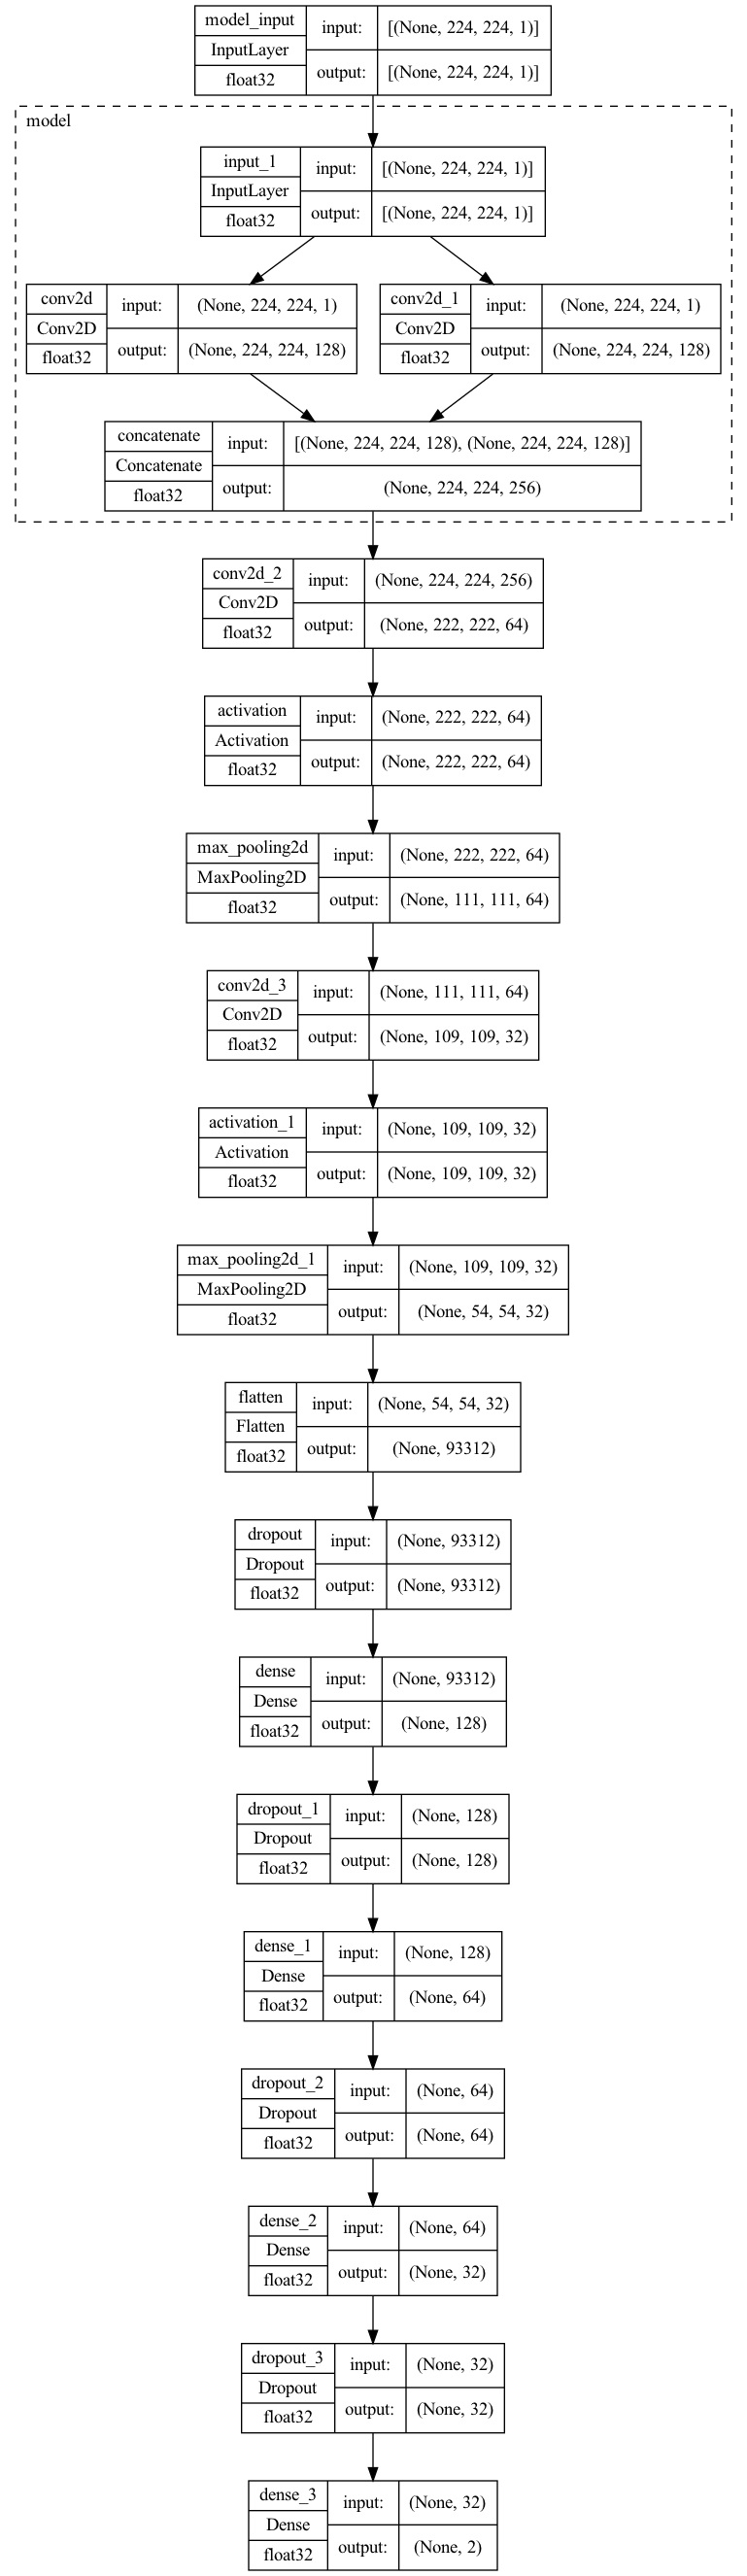

In [16]:
# plot model as image
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)

In [17]:
#date labeling confusion was removed 

X_train =train_data
Y_train =train_target

x_test =test_data
y_test = test_target


# Valued to plot in epochs traing's history

## Training and validation accuracy Model

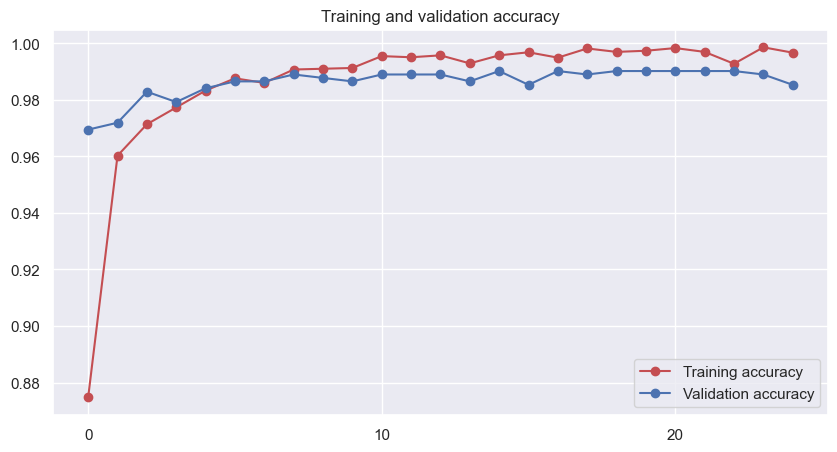

<Figure size 640x480 with 0 Axes>

In [18]:
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy', marker="o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker="o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()
plt.show()

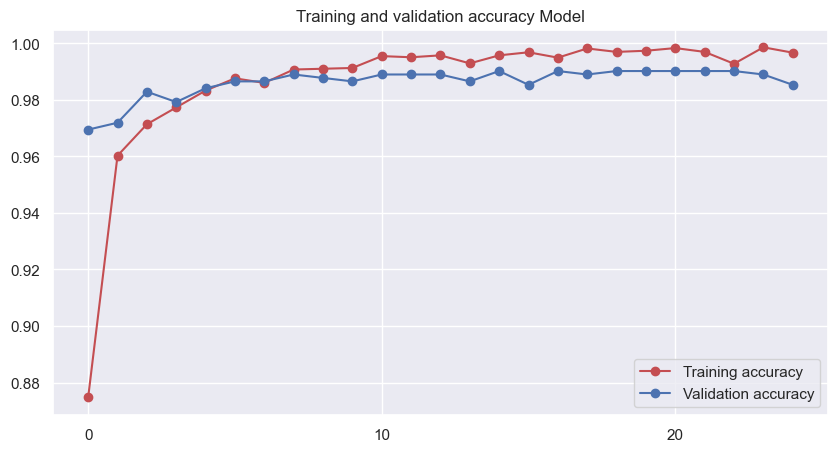

<Figure size 640x480 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()
plt.show()

## Training and validation Loss Model

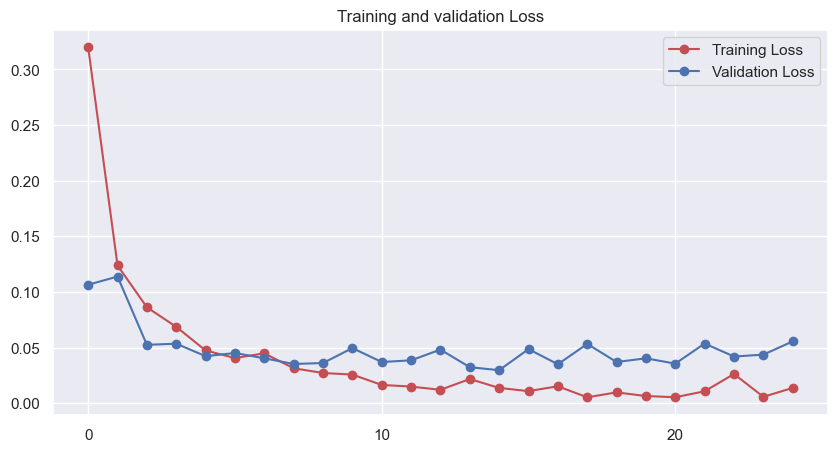

<Figure size 640x480 with 0 Axes>

In [20]:
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0, len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

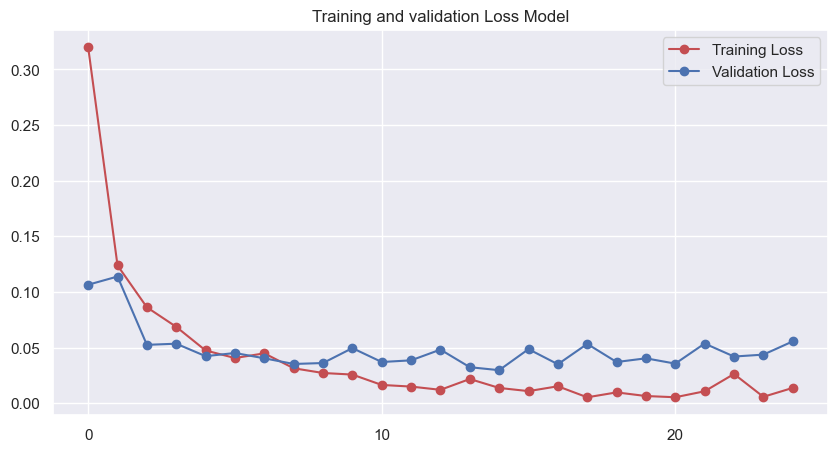

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['loss']
val_loss = history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Sparse categorical accuracy Model

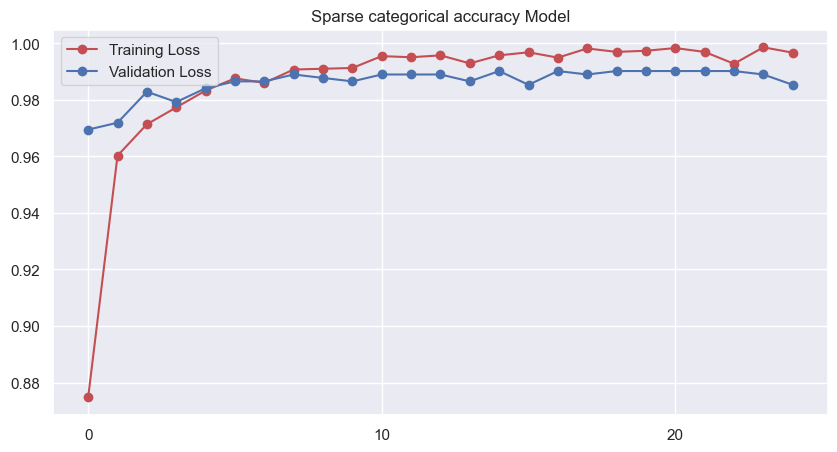

<Figure size 640x480 with 0 Axes>

In [22]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_sparse_categorical_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Sparse categorical accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared error in model

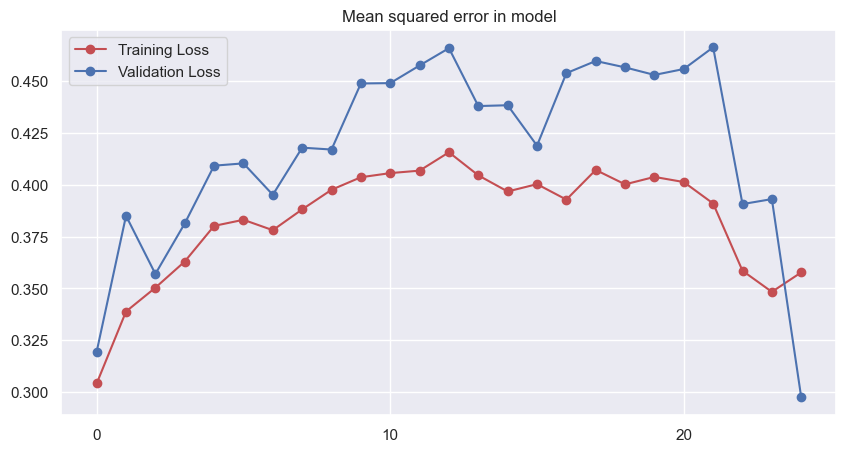

<Figure size 640x480 with 0 Axes>

In [23]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared absolute error in model

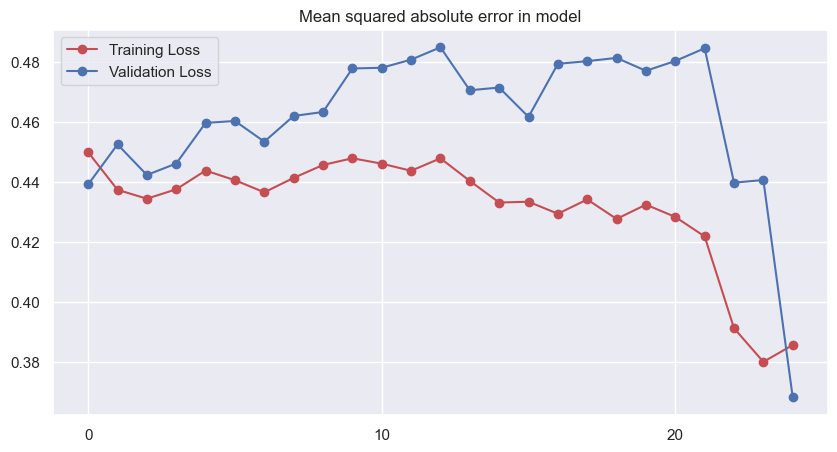

<Figure size 640x480 with 0 Axes>

In [24]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared absolute error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean absolute percentage error in model

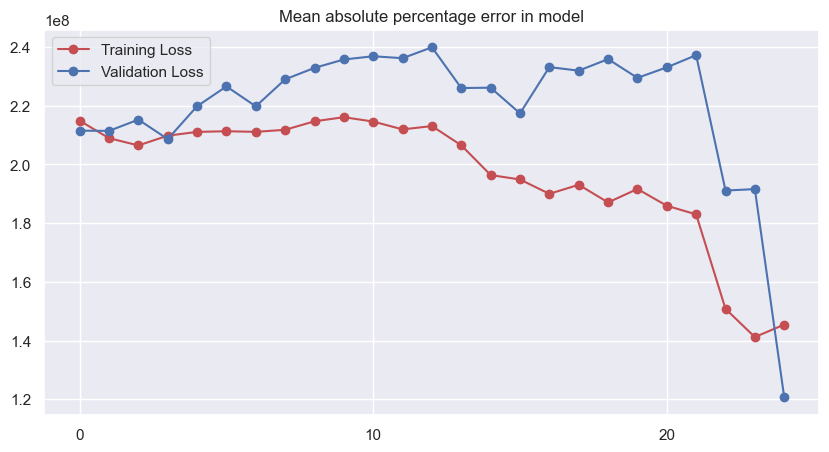

<Figure size 640x480 with 0 Axes>

In [25]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_absolute_percentage_error']
val_loss = history.history['val_mean_absolute_percentage_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean absolute percentage error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared logarithmic error in model

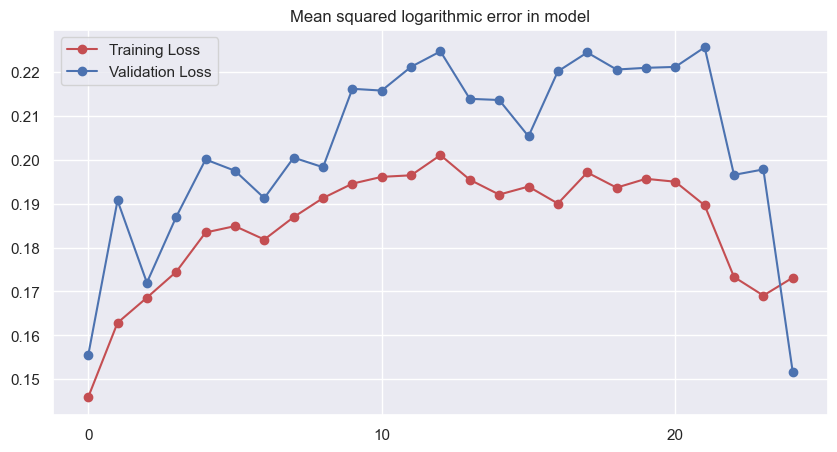

<Figure size 640x480 with 0 Axes>

In [26]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['mean_squared_logarithmic_error']
val_loss = history.history['val_mean_squared_logarithmic_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Mean squared logarithmic error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Cosine similarity in model

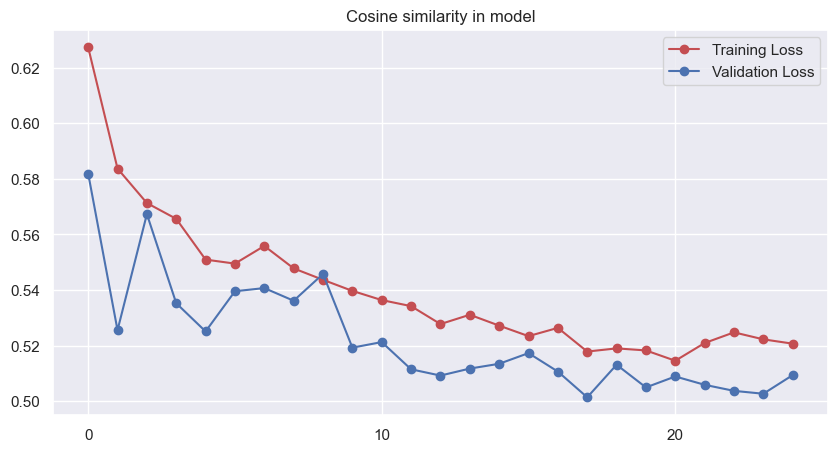

<Figure size 640x480 with 0 Axes>

In [27]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['cosine_similarity']
val_loss = history.history['val_cosine_similarity']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Cosine similarity in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Log-Cosh Loss

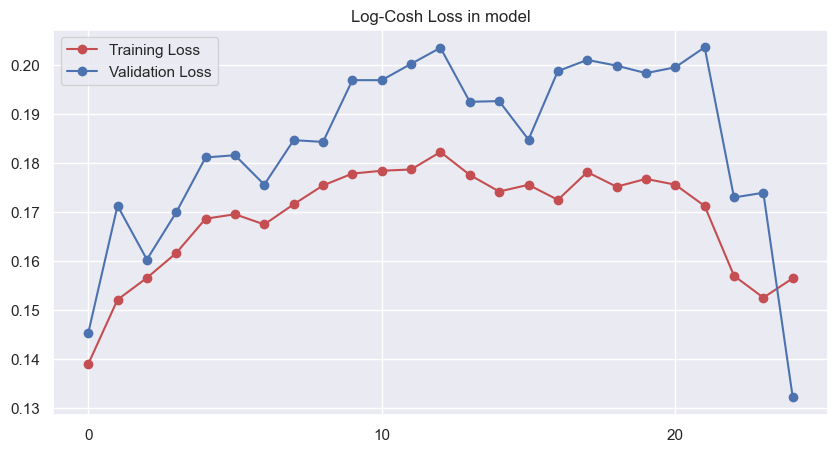

<Figure size 640x480 with 0 Axes>

In [28]:

sns.set()
epochs = range(0,len(acc))
loss = history.history['logcosh']
val_loss = history.history['val_logcosh']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Log-Cosh Loss in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

# Model Evaluation Results

## Model Evaluation Results

In [ ]:
## Model Evaluation Results

score = model.evaluate(test_data,test_target)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])
print('\nTest loss(%):', score[0]*100)
print('Test accuracy(%):', score[1]*100)

## Confution Matrix

 1/26 [>.............................] - ETA: 10s

2022-10-26 13:43:46.624130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 11s 418ms/step


<Figure size 1000x500 with 0 Axes>

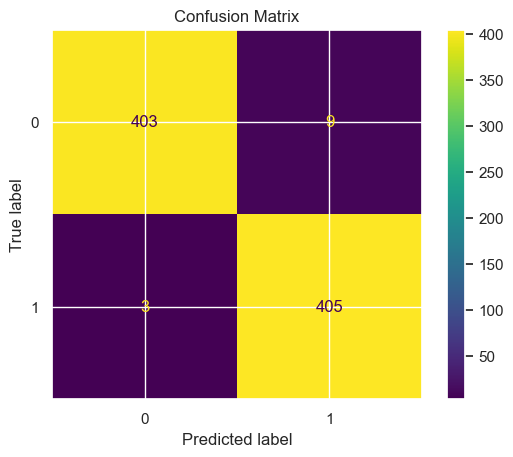

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig = plt.gcf()
fig.set_size_inches(10, 5)

clf = model
pred = model.predict(x_test)[:, 1]
# print(pred)
predictions = (pred > 0.5).astype(int)
# print(predictions)
# print(y_test)
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.figure()
plt.show()

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)

403 9 3 405


## Sensitivity / True Positive Rate

In [32]:
# Sensitivity = True Positives/ (True Positives + True Negatives)
sensitivity = tp / (tp + tn)
print(f"Sensitivity : {sensitivity}")

Sensitivity : 0.5012376237623762


## Specificity / True Negative Rate:

In [33]:
# Specificity = True Negatives/ (False Positives + True Negatives)
specificity = tn / (fp+tn)
print(f"Specificity : {specificity}")

Specificity : 0.9781553398058253


## ROC AUC Score

In [34]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

# The area under the ROC curve (AUC) results were considered 
# excellent for AUC values between 0.9-1
# good for AUC values between 0.8-0.9 
# fair for AUC values between 0.7-0.8
# poor for AUC values between 0.6-0.7 
# failed for AUC values between 0.5-0.6

ROC AUC: 0.9854


## ROC Curve

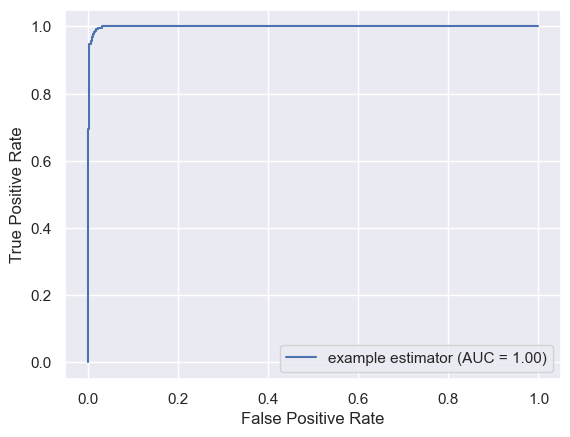

In [35]:
import matplotlib.pyplot as plt

from sklearn import metrics


fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

##  Classification Report

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       412
           1       0.98      0.99      0.99       408

    accuracy                           0.99       820
   macro avg       0.99      0.99      0.99       820
weighted avg       0.99      0.99      0.99       820



/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2148: UserWarning: labels size, 10, does not match size of target_names, 9
  warnings.warn(
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.p

<AxesSubplot: >

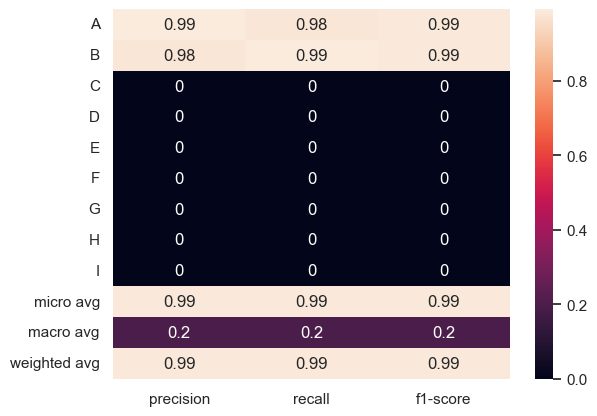

In [36]:
from sklearn.metrics import classification_report
import seaborn as sns
target_names = list("ABCDEFGHI")
labels = np.arange(10)

classification_report_1 = classification_report(y_test, predictions)
print(classification_report_1)
classification_report = classification_report(y_test, predictions,labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)


## Accuracy Score

In [37]:
from sklearn.metrics import accuracy_score
y_pred = predictions
y_true = y_test

ac_s_without_normalize = accuracy_score(y_true, y_pred)
print(f"Accuracy score without normalize : {ac_s_without_normalize}")

ac_s_with_normalize =accuracy_score(y_true, y_pred, normalize=False)
print(f"Accuracy score with normalize: {ac_s_with_normalize}")

Accuracy score without normalize : 0.9853658536585366
Accuracy score with normalize: 808


## Balance Accuracy Score

In [38]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy score : {balanced_accuracy_score}")

Balanced accuracy score : 0.9854011993146774


## Average precision score

In [39]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score(y_true, y_pred)
print(f"Average precision score : {average_precision_score}")

Average precision score : 0.9747263115214273


## Precision Score

Precision score macro : 0.9854358535018205
Precision score micro : 0.9853658536585366
Precision score weighted : 0.9854708534234624
Precision score : [0.99261084 0.97826087]


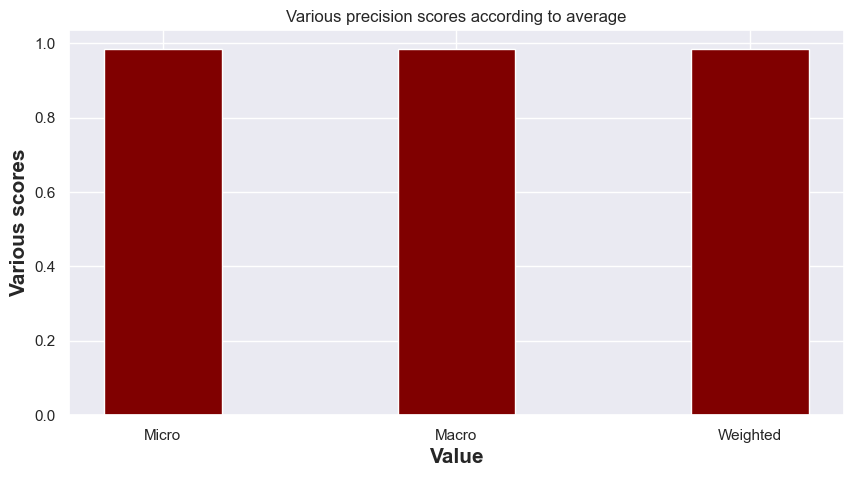

In [40]:
from sklearn.metrics import precision_score

precision_score_macro = precision_score(y_true, y_pred, average='macro')

precision_score_micro = precision_score(y_true, y_pred, average='micro')

precision_score_weighted = precision_score(y_true, y_pred, average='weighted')

precision_score = precision_score(y_true, y_pred, average=None)

print(f"Precision score macro : {precision_score_macro}")
print(f"Precision score micro : {precision_score_micro}")
print(f"Precision score weighted : {precision_score_weighted}")
print(f"Precision score : {precision_score}")


data = {'Micro':precision_score_macro, 'Macro':precision_score_micro, 'Weighted':precision_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various precision scores according to average")
plt.show()


## Recall Score

Recall score macro : 0.9854011993146774
Recall score micro : 0.9853658536585366
Recall score weighted : 0.9853658536585366
Recall score : [0.97815534 0.99264706]


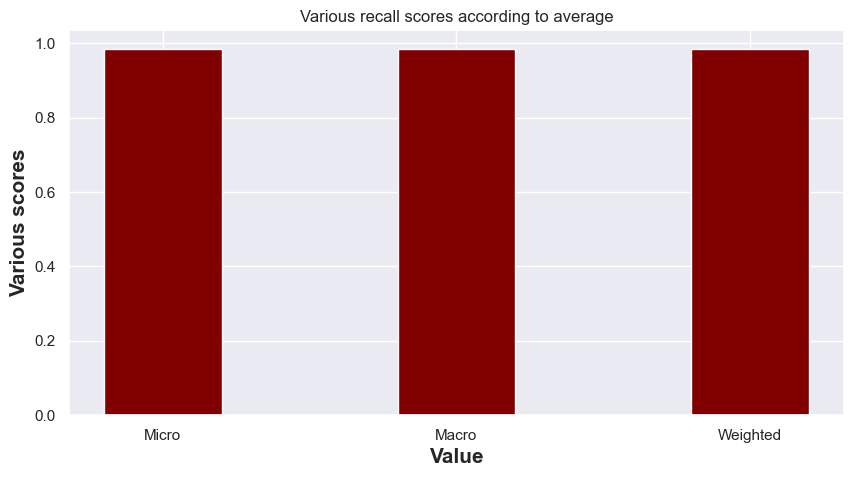

In [41]:
from sklearn.metrics import recall_score

recall_score_macro =recall_score(y_true, y_pred, average='macro')

recall_score_micro =recall_score(y_true, y_pred, average='micro')

recall_score_weighted =recall_score(y_true, y_pred, average='weighted')

recall_score =recall_score(y_true, y_pred, average=None)


print(f"Recall score macro : {recall_score_macro}")
print(f"Recall score micro : {recall_score_micro}")
print(f"Recall score weighted : {recall_score_weighted}")
print(f"Recall score : {recall_score}")

data = {'Micro':recall_score_macro, 'Macro':recall_score_micro, 'Weighted':recall_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various recall scores according to average")
plt.show()

## F1 Score

Recall score macro : 0.985365766601824
Recall score micro : 0.9853658536585366
Recall score weighted : 0.9853655924883986
Recall score : [0.98533007 0.98540146]


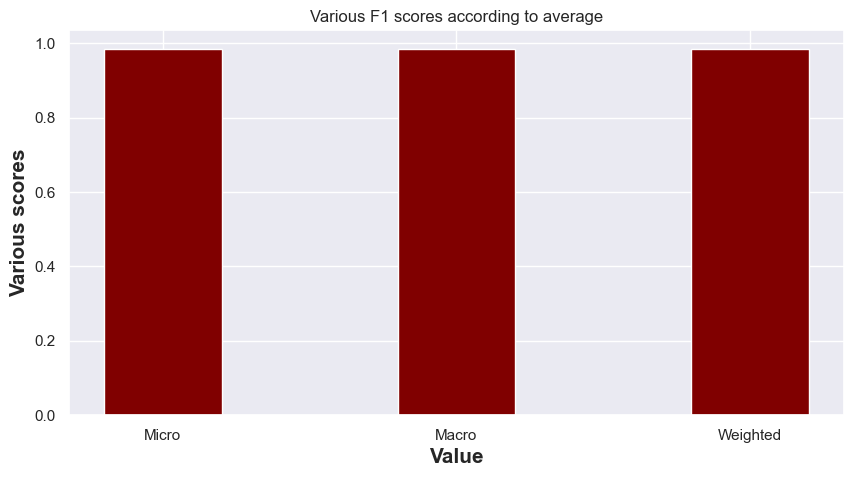

In [42]:
from sklearn.metrics import f1_score

f1_score_macro=f1_score(y_true, y_pred, average='macro')

f1_score_micro=f1_score(y_true, y_pred, average='micro')

f1_score_weighted=f1_score(y_true, y_pred, average='weighted')

f1_score=f1_score(y_true, y_pred, average=None)

print(f"Recall score macro : {f1_score_macro}")
print(f"Recall score micro : {f1_score_micro}")
print(f"Recall score weighted : {f1_score_weighted}")
print(f"Recall score : {f1_score}")

data = {'Micro':f1_score_macro, 'Macro':f1_score_micro, 'Weighted':f1_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various F1 scores according to average")
plt.show()

## Binary accuracy

In [43]:
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)
print(f"Binary accuracy: {m}")


Binary accuracy: 0.9853658676147461


## Categorical accuracy

In [44]:
m = tf.keras.metrics.categorical_accuracy(y_true, y_pred)
print(f"Categorical accuracy: {m}")



Categorical accuracy: 1.0


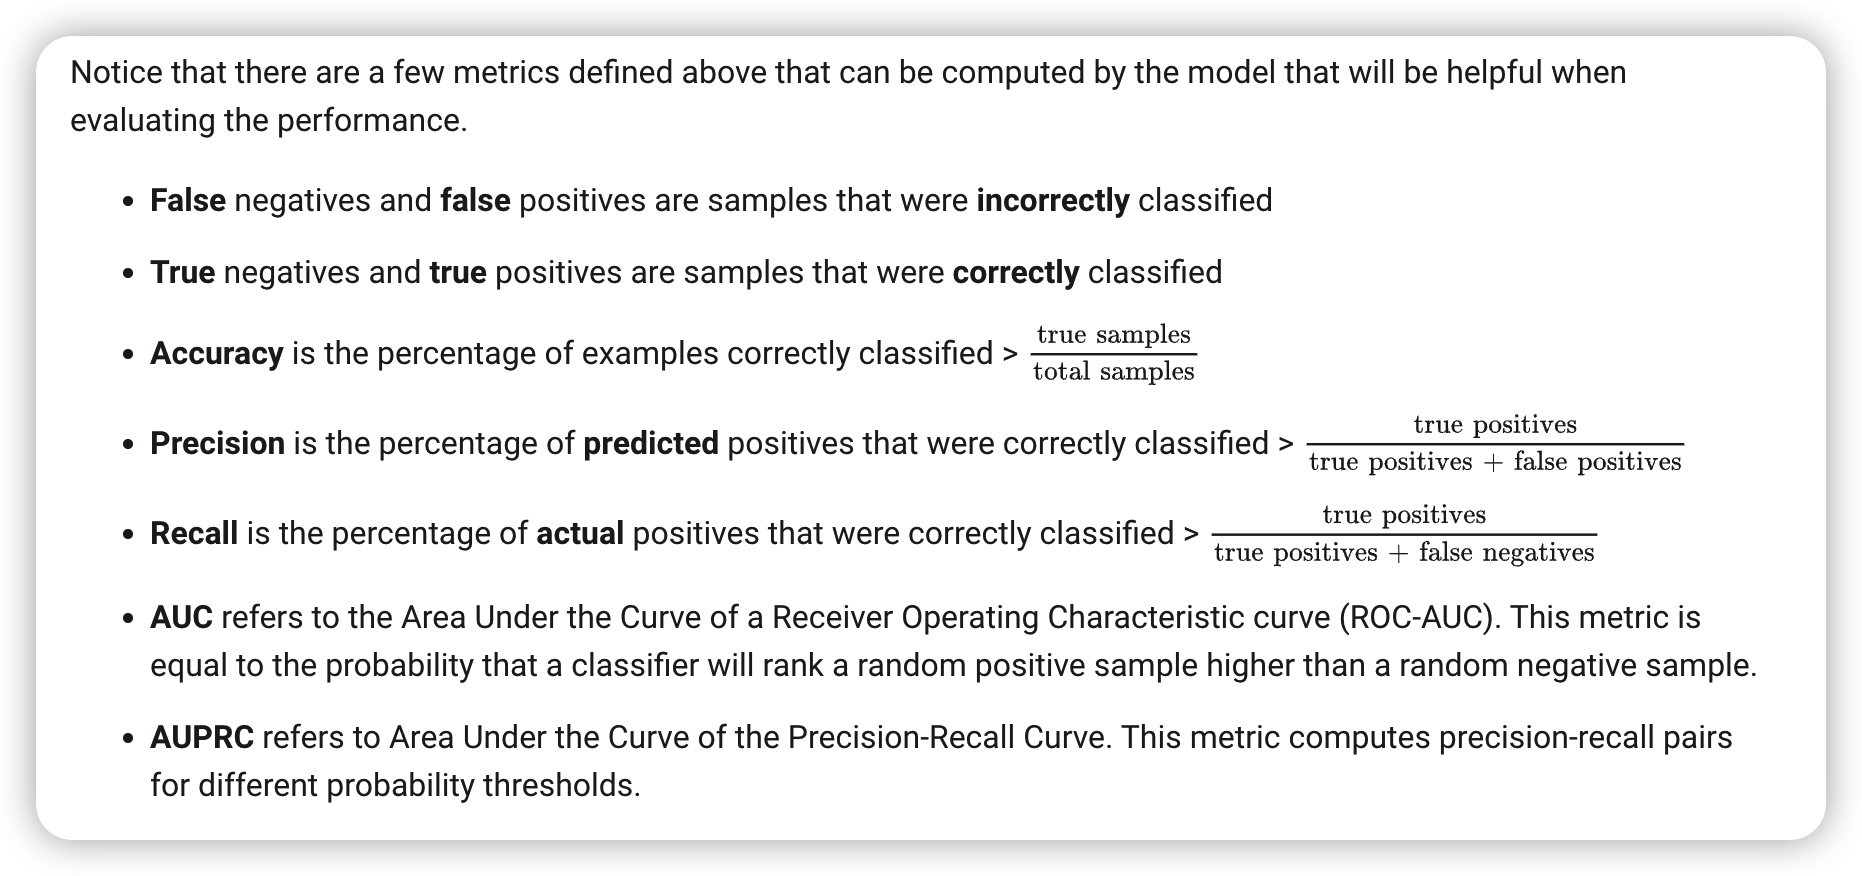

